In [1]:
## Display Hardware used for training and testing the model 
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2060


In [2]:
## Imports 
## Below code is borrowed from pytorch tutorial (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and modifed as per requirement.
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil



plt.ion()

In [3]:
## Extract data set from zip file

# import zipfile
# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')
    


In [4]:
## prepare data set into train, test and validation

## label map 

labels_map = {
    '1': "glass",
    '2': "paper",
    '3': "cardboard",
    '4': "plastic",
    '5': "metal",
    '6': "trash"
}

def make_dir():
    for i in ['train','test','val']:
        parent_dir = "GarbageHarvester/"
        for j in labels_map.values():
            directory=i+'/'+j
            path = os.path.join(parent_dir, directory)
            if not os.path.exists(path):
                os.mkdir(path)

def organize_dataset(datasettype):
    make_dir()
    with open('one-indexed-files-notrash_'+datasettype+'.txt') as f:
        line = f.readline()
        while line:
            line = f.readline()
            l= line.split(' ')
            cleanlist= list(map(lambda x:x.strip(),l))
            print(labels_map[cleanlist[1]])
            shutil.copyfile('Garbageclassification/'+labels_map[cleanlist[1]]+'/'+cleanlist[0], 'GarbageHarvester/'+datasettype+'/'+labels_map[cleanlist[1]]+'/'+cleanlist[0])

## Run only once else it will cause exception. need to fix this bug later.
#organize_dataset('train')         
#organize_dataset('test')         
#organize_dataset('val')         



In [5]:
# Data Preparation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'GarbageHarvester'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


{'train': 1767, 'test': 430, 'val': 327}


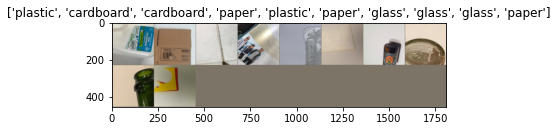

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [7]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())                
    best_model_wts_test = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_test= 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            if phase == 'test':
                model.eval()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
     
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'test' and epoch_acc > best_acc_test:
                best_acc_test = epoch_acc
                best_model_wts_test = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best test Acc: {:4f}'.format(best_acc_test))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
## Confusion Matrix and graphs
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# def confusion_matrix(actual,predicted,txt='dk'):
#     conf=confusion_matrix(actual,predicted)
#     print(conf)


In [9]:
def visualize_model(model, phase,batch_size, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure()
    cms=np.zeros_like(6)
    y_expected_all=torch.tensor([],dtype=torch.int32)
    y_predicted_all=torch.tensor([],dtype=torch.int32)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #print(inputs.size())
            #print(confusion_matrix(labels.cpu().data,preds.cpu().data))
            #print(labels.cpu().data)
            #print(preds.cpu().data)
            
            y_expected=labels.cpu().data
            y_predicted= preds.cpu().data
            
            y_expected_all=torch.cat((y_expected_all,y_expected),dim=0)
            y_predicted_all=torch.cat((y_predicted_all,y_predicted),dim=0)
            
            
            cm = confusion_matrix(y_expected,y_predicted,labels=[0,1,2,3,4,5])
            cms=cm+cms
            #print(cms)
            
            #print(inputs.size())

            for j in range(batch_size):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
#                 imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        print("################Confusion Matrix####################")
        disp = ConfusionMatrixDisplay(confusion_matrix=cms,display_labels=[0,1,2,3,4,5])
        disp.plot()
        plt.show()
        #importing accuracy_score, precision_score, recall_score, f1_score
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_expected_all, y_predicted_all)))

        print('Micro Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='micro')))
        print('Micro Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='micro')))
        print('Micro F1-score: {:.2f}\n'.format(f1_score(y_expected_all, y_predicted_all, average='micro')))

        print('Macro Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='macro')))
        print('Macro Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='macro')))
        print('Macro F1-score: {:.2f}\n'.format(f1_score(y_expected_all, y_predicted_all, average='macro')))

        print('Weighted Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='weighted')))
        print('Weighted Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='weighted')))
        print('Weighted F1-score: {:.2f}'.format(f1_score(y_expected_all, y_predicted_all, average='weighted')))

        from sklearn.metrics import classification_report
        print('\nClassification Report\n')
        print(classification_report(y_expected_all, y_predicted_all, target_names=['0','1','2','3','4','5']))
        
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.2086 Acc: 0.5342
test Loss: 0.8547 Acc: 0.7023
val Loss: 0.7873 Acc: 0.7187

Epoch 1/49
----------
train Loss: 0.9073 Acc: 0.6746
test Loss: 0.7592 Acc: 0.7349
val Loss: 0.8222 Acc: 0.7217

Epoch 2/49
----------
train Loss: 0.7545 Acc: 0.7221
test Loss: 0.7819 Acc: 0.7140
val Loss: 0.8567 Acc: 0.7156

Epoch 3/49
----------
train Loss: 0.7499 Acc: 0.7295
test Loss: 0.6109 Acc: 0.7953
val Loss: 0.5690 Acc: 0.8012

Epoch 4/49
----------
train Loss: 0.6308 Acc: 0.7753
test Loss: 0.4765 Acc: 0.8326
val Loss: 0.5042 Acc: 0.8287

Epoch 5/49
----------
train Loss: 0.5254 Acc: 0.7980
test Loss: 0.6841 Acc: 0.7744
val Loss: 0.6705 Acc: 0.7798

Epoch 6/49
----------
train Loss: 0.5296 Acc: 0.8217
test Loss: 0.5372 Acc: 0.8023
val Loss: 0.4928 Acc: 0.8104

Epoch 7/49
----------
train Loss: 0.3417 Acc: 0.8710
test Loss: 0.3404 Acc: 0.8628
val Loss: 0.3580 Acc: 0.8777

Epoch 8/49
----------
train Loss: 0.2736 Acc: 0.9027
test Loss: 0.3175 Acc: 0.8860
val Loss: 0.3

{'0': 'glass', '1': 'paper', '2': 'cardboard', '3': 'plastic', '4': 'metal', '5': 'trash'}
###############validation####################
################Confusion Matrix####################


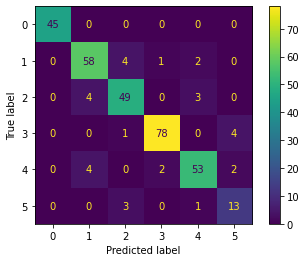


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.88
Macro Recall: 0.89
Macro F1-score: 0.88

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.91

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.88      0.89      0.89        65
           2       0.86      0.88      0.87        56
           3       0.96      0.94      0.95        83
           4       0.90      0.87      0.88        61
           5       0.68      0.76      0.72        17

    accuracy                           0.91       327
   macro avg       0.88      0.89      0.88       327
weighted avg       0.91      0.91      0.91       327

###############test####################
################Confusion Matrix####################


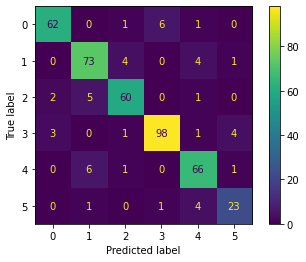


Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.88
Macro Recall: 0.88
Macro F1-score: 0.88

Weighted Precision: 0.89
Weighted Recall: 0.89
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        70
           1       0.86      0.89      0.87        82
           2       0.90      0.88      0.89        68
           3       0.93      0.92      0.92       107
           4       0.86      0.89      0.87        74
           5       0.79      0.79      0.79        29

    accuracy                           0.89       430
   macro avg       0.88      0.88      0.88       430
weighted avg       0.89      0.89      0.89       430



In [12]:
#input loaded from one index file.. but data loader shows them as zero indexed.
print("{'0': 'glass', '1': 'paper', '2': 'cardboard', '3': 'plastic', '4': 'metal', '5': 'trash'}")
print('###############validation####################')
visualize_model(model_ft,'val',327,327)
print('###############test####################')
visualize_model(model_ft,'test',430,430)
